# Crypto Currency Analysis

Crpytocurrency exchanges are websites that enable the purchase, sale, and exchange of cryptocurrencies. These exchanges provide liquidity for owners and establish the relative value of these currencies. As of this writing (mid-2022), [it is estimated](https://www.statista.com/statistics/730876/cryptocurrency-maket-value/) that cryptocurrencies have a collective market capitalization of more than 2 trillion USD. Cryptocurrency markets are constantly changing with new entrants, the occasional collapse of a currency, and highly volatile prices.

The purpose of this notebook is to explore the efficiency of cryptocurrency exchanges by testing for arbitrage opportunities. An arbitrage exists if a customer can realize a net profit through a sequence of risk-free trades. The efficient market hypothesis assumes arbitrage opportunities are quickly identified and exploited by investors. As a result of their trading, prices would reach a new equilibrium so that in an efficient market, any arbitrage opportunities would be small and fleeting. 

Still, the market has to get to equilibrium somehow. So it is possible, with real-time data and rapid execution, a trader can be in a position to profit from these fleeting arbitrage opportunities?

## Installations and Imports

This notebook requires multiple libraries. The following cell performs the required installations for Google Colab. To run in your own environment you will need to install `pyomo`,`ccxt`, and `networkx` python libraries, and a linear solver for Pyomo.

In [40]:
import os
import sys
from time import time
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyomo.environ as pyo

if "google.colab" in sys.modules:
    !pip install -q ccxt
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Cryptocurrency Exchanges

Cryptocurrency exchanges are digital marketplaces for buying and trading cryptocurrencies. Joining an exchange enables a user to maintain multiple currencies in a digital wallet, buy and sell currencies, and to use cryptocurrencies in financial transactions. The [open-source library `ccxt`](https://github.com/ccxt/ccxt) currently supports real-time APIs for the largest and most common exchanges on which cryptocurrencies are traded. Here we import the library and list current exchanges supported by `ccxt`.

In [41]:
import ccxt

for i, exchange in enumerate(ccxt.exchanges):
    print(f"{i+1:3d}) {exchange.ljust(20)}", end="" if (i+1) % 4 else "\n")

  1) aax                   2) ascendex              3) bequant               4) bibox               
  5) bigone                6) binance               7) binancecoinm          8) binanceus           
  9) binanceusdm          10) bit2c                11) bitbank              12) bitbay              
 13) bitbns               14) bitcoincom           15) bitfinex             16) bitfinex2           
 17) bitflyer             18) bitforex             19) bitget               20) bithumb             
 21) bitmart              22) bitmex               23) bitopro              24) bitpanda            
 25) bitrue               26) bitso                27) bitstamp             28) bitstamp1           
 29) bittrex              30) bitvavo              31) bkex                 32) bl3p                
 33) blockchaincom        34) btcalpha             35) btcbox               36) btcmarkets          
 37) btctradeua           38) btcturk              39) buda                 40) bw         

## Representing an Exchange as a Directed Graph

Each exchange `ccxt` consists of multiple markets. Each market consists of all trading done between two specific currencies. `ccxt` labels each market with a symbol that is common across exchanges and suitable for within-exchange and cross-exchange arbitrage analyses.

The market symbol is an upper case string consisting of a slash (`/`) that separate abbreviations for a pair of traded currencies. The first abbreviation is for the base currency, the second is for the quote currency.  Prices for the base currency are denominated in units of the quote currency. As an example, the symbol `ETH/BTC` refers to a market for the base currency Ethereum (ETH) quoted in units of the Bitcoin(BTC).

A directed graph can be constructed from the market symbols available on a single exchange. Currencies are represented by nodes on the directed graph. Market symbols correspond to edges in the directed graph, with the source indicating the quote currency and the destination indicating the base currency.

The in-degree of a node refers to the number of incoming edges. Out-degree refers to the number of outgoing edges. Nodes with out-degrees greater than zero are highlighted because they represent currencies used to quote the price of other currencies. For all other nodes, a `minimum_in_degree` specifies a threshold value for in_degree for nodes to be displayed and retained for further analysis.



Number of nodes =  15
Number of edges =  50


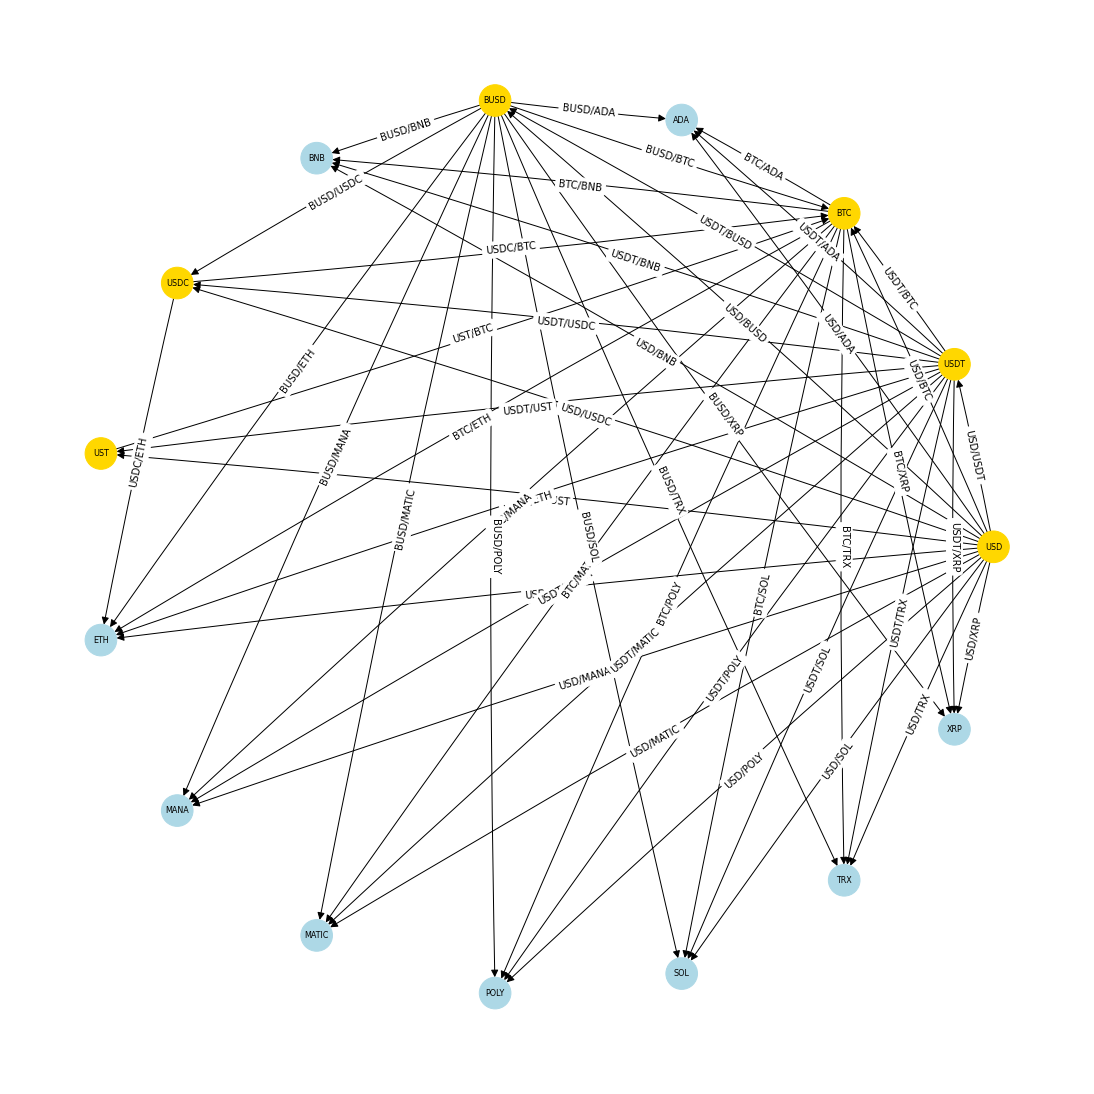

In [42]:
# global variables used in subsequent cells
exchange = ccxt.binanceus()
markets = exchange.load_markets()
symbols = exchange.symbols


def symbols_to_dg(symbols, minimum_in_degree=1):

    # create an edge for every symbol
    dg = nx.DiGraph()
    for base, quote in [symbol.split("/") for symbol in symbols]:
        dg.add_edge(quote, base)

    remove_nodes = []
    for node in dg.nodes():
        if dg.out_degree(node) > 0:
            # color quote currencies in gold
            dg.nodes[node]["color"] = "gold"
        else:
            if dg.in_degree(node) < minimum_in_degree:
                # remove base currencies with an insufficint in_degree
                remove_nodes.append(node)
            else:
                # color base currencies in lightblue
                dg.nodes[node]["color"] = "lightblue"

    dg.remove_nodes_from(remove_nodes)
    return dg


def draw_dg(dg, rad=0.0):

    fig = plt.figure(figsize=(15, 15))
    pos = nx.circular_layout(dg)
    nx.draw(
        dg,
        pos,
        with_labels=True,
        node_color=[dg.nodes[node]["color"] for node in dg.nodes()],
        node_size=1000,
        font_size=8,
        arrowsize=15,
        connectionstyle=f"arc3, rad={rad}",
    )
    nx.draw_networkx_edge_labels(
        dg, pos, edge_labels={(src, dst): f"{src}/{dst}" for src, dst in dg.edges()}
    )


dg_symbols = symbols_to_dg(symbols, 4)
draw_dg(dg_symbols, 0.01)

print(f"Number of nodes = {len(dg_symbols.nodes()):3d}")
print(f"Number of edges = {len(dg_symbols.edges()):3d}")

The order book for a currency exchange is the real-time inventory of trading orders. 

A **bid** is an order to buy up to a specified amount of the base currency at a price no greater than value specified in the quote currency. The exchange attempts to match the bid to a sell order at a price less than or equal to the bid price. If a transaction occurs, the  buyer will receive an amount of base currency less than or equal to the bid volume at a prices less than or equal to the bid price.

An **ask** is an offer to sell up to a specified amount of the base currency at a price no less than a value specified given in the quote currency. If a transaction occurs, then seller will sell no more than a specified about of the base currency at a price no less than the specified value if the exchange matches the ask order to a higher bid. 

The exchange order book maintains a list of all active orders for symbols traded on the exchange. Incoming bids above the lowest ask or incoming asks below the highest bid will be immediately matched and transactions executed following rules of the exchange. 

The following cell uses the `ccxt` library to fetch the highest bid and lowest ask from the order book for all trading symbols in a directed graph.

## Exchange Order Book

In [49]:
import pandas as pd


def fetch_order_book(dg):

    # get trading symbols from exchange graph
    trade_symbols = ["/".join([base, quote]) for quote, base in dg.edges()]

    def fetch_order_book_symbol(symbol, limit=1, exchange=exchange):
        """return order book data for a specified symbol"""
        start_time = timer()
        result = exchange.fetch_order_book(symbol, limit)
        result["base"], result["quote"] = symbol.split("/")
        result["run_time (ms)"] = round(1000 * (timer() - start_time), 1)
        result["timestamp"] = exchange.milliseconds()
        if result["bids"]:
            result["bid_price"] = result["bids"][0][0]
            result["bid_volume"] = result["bids"][0][1]
        if result["asks"]:
            result["ask_price"] = result["asks"][0][0]
            result["ask_volume"] = result["asks"][0][1]
        return result

    # fetch order book data and store in a dictionary
    order_book = {symbol: fetch_order_book_symbol(symbol) for symbol in trade_symbols}

    # convert to pandas dataframe
    order_book = pd.DataFrame(order_book).T
    order_book.drop(columns=["datetime", "symbol"], inplace=True)
    order_book["timestamp"] = pd.to_datetime(order_book["timestamp"], unit="ms")

    return order_book


order_book = fetch_order_book(dg_symbols)
display(order_book)

,bids,asks,timestamp,nonce,base,quote,run_time (ms),bid_price,bid_volume,ask_price,ask_volume
ADA/USD,"[[0.5177, 37.5]]","[[0.5179, 2998.1]]",2022-07-29 02:44:19.747,1055098812,ADA,USD,314.9,0.5177,37.5,0.5179,2998.1
BNB/USD,"[[275.7121, 0.797]]","[[275.8169, 0.797]]",2022-07-29 02:44:19.886,1409207490,BNB,USD,139.0,275.7121,0.797,275.8169,0.797
BTC/USD,"[[23824.45, 0.205]]","[[23832.36, 0.062936]]",2022-07-29 02:44:19.954,2305107557,BTC,USD,68.2,23824.45,0.205,23832.36,0.062936
BUSD/USD,"[[0.9999, 554677.04]]","[[1.0, 628480.59]]",2022-07-29 02:44:20.022,10661420,BUSD,USD,68.2,0.9999,554677.04,1.0,628480.59
ETH/USD,"[[1715.01, 1.75]]","[[1715.49, 0.06334]]",2022-07-29 02:44:20.095,1975889653,ETH,USD,72.9,1715.01,1.75,1715.49,0.06334
MANA/USD,"[[1.0072, 486.04]]","[[1.0083, 406.68]]",2022-07-29 02:44:20.163,735062262,MANA,USD,67.9,1.0072,486.04,1.0083,406.68
MATIC/USD,"[[0.9724, 770.0]]","[[0.973, 550.0]]",2022-07-29 02:44:20.234,1095767233,MATIC,USD,70.7,0.9724,770.0,0.973,550.0
POLY/USD,"[[0.2137, 3982.9]]","[[0.2147, 1590.6]]",2022-07-29 02:44:20.307,6247568,POLY,USD,73.7,0.2137,3982.9,0.2147,1590.6
SOL/USD,"[[43.0802, 29.4]]","[[43.088, 0.83]]",2022-07-29 02:44:20.377,1298977591,SOL,USD,69.8,43.0802,29.4,43.088,0.83
TRX/USD,"[[0.0695, 462629.4]]","[[0.0696, 718.7]]",2022-07-29 02:44:20.449,9147814,TRX,USD,72.1,0.0695,462629.4,0.0696,718.7


The order book can be represented as a directed graph.

A market symbol is a text string of the form $b/q$ where $b$ refers to a base currency, and $q$ refers to quote currency $q$. A sell order for symbol $b/q$ provides a prospective buyer an opportunity to purchase currency $b$ at the specified 'ask' price. A sell order is represented on the directed graph by a directed edge from the quote currency to the base currency that is labeled with a coefficient $a_{q\rightarrow b}$ equal to inverse of the ask price. The coefficient represents the conversion of one unit of the quote currency into $a_{q\rightarrow b}$ units of the base currency. The capacity of the edge, $c_{q\rightarrow b}$, is equal to the units of base currency available for trading in this sell order. The capacity is computed by multiplying the ask volume of the order book by the ask price.

A buy order $b/q$ is an opportunity for a seller to sell an amount of currency $b$ at the specified 'bid' price given in units of the quote currency. The is represented in the directed graph by an edge from the base currency to the quote currency with a coefficient $a_{b\rightarrow q}$ equal to the bid price. The trade results each unit of the base currency being converted to $a_{b\rightarrow q}$ units of the quote currency. The capacity of the edge $c_{b\rightarrow q}$ is equal to specified volume of the buy order.

For the purpose of identifying arbitrage opportunities, the the node referring to USD is split into two nodes, USD-SRC and USD-DST. All edges where USD is exchanged for another currency are linked to USD-SRC. All edges where a currency is exchanged for USD are linked to USD-DST. With this distinction, shortest path path algorithms where the negative logarithmic return is interpreted as distance, can be used to find arbitrage opportunities resulting in net gain in a fiat currency.

## Order Book as a Directed Graph

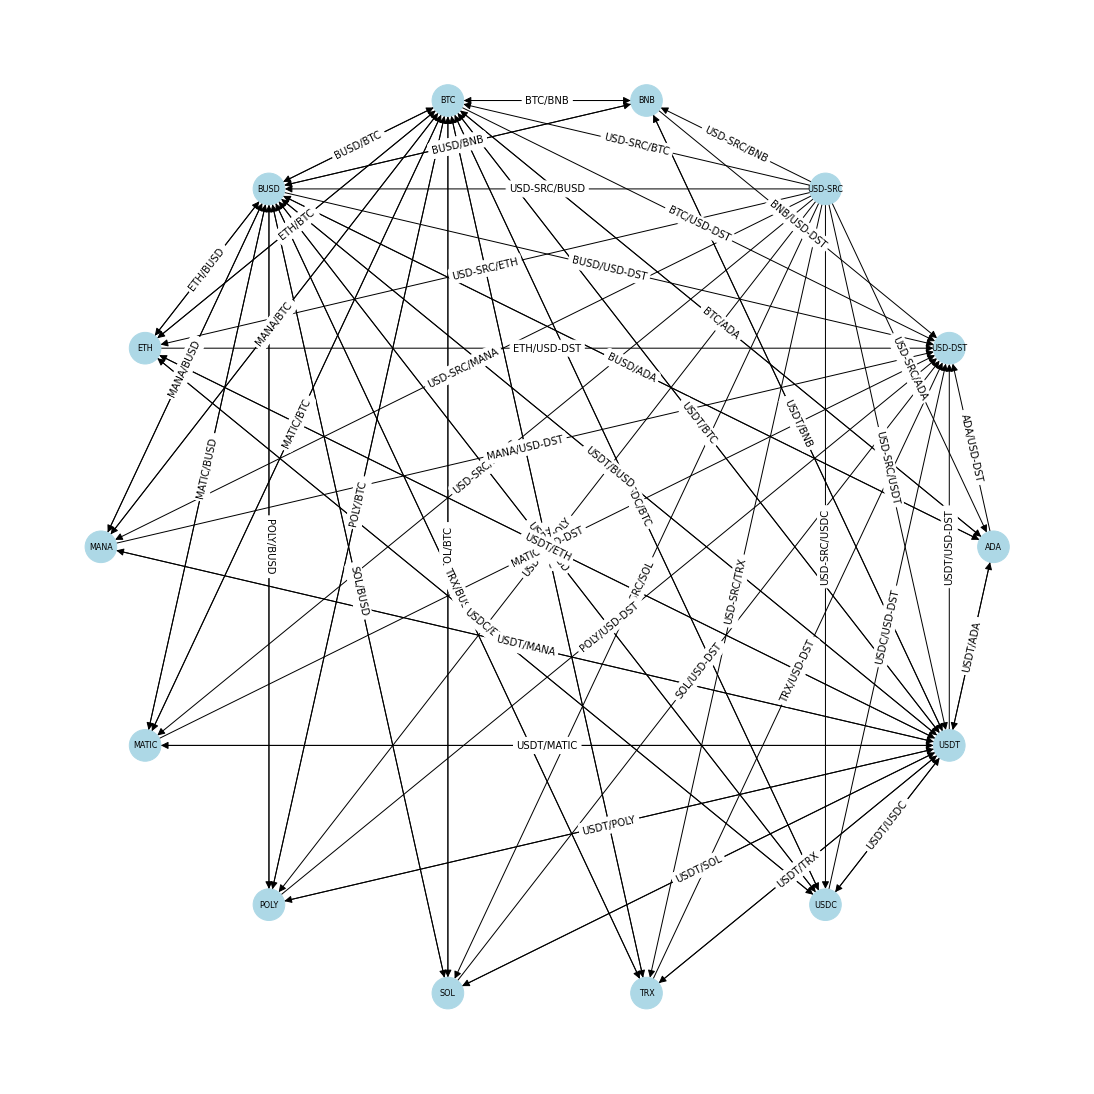

In [50]:
def order_book_to_dg(order_book):

    # create a dictionary of edges index by (src, dst)
    edges = dict()
    for symbol in order_book.index:
        # buy orders
        if not np.isnan(order_book.at[symbol, "bid_volume"]):
            src = order_book.at[symbol, "base"]
            src = "USD-SRC" if src == "USD" else src
            dst = order_book.at[symbol, "quote"]
            dst = "USD-DST" if dst == "USD" else dst
            edges[(src, dst)] = {
                "type": "bid",
                "a": order_book.at[symbol, "bid_price"],
                "log_a": np.log(order_book.at[symbol, "bid_price"]),
                "c": order_book.at[symbol, "bid_volume"],
            }
        # sell orders
        if not np.isnan(order_book.at[symbol, "ask_volume"]):
            src = order_book.at[symbol, "quote"]
            src = "USD-SRC" if src == "USD" else src
            dst = order_book.at[symbol, "base"]
            dst = "USD-DST" if dst == "USD" else dst
            edges[(src, dst)] = {
                "type": "ask",
                "a": 1.0 / order_book.at[symbol, "ask_price"],
                "log_a": np.log(1.0 / order_book.at[symbol, "ask_price"]),
                "c": order_book.at[symbol, "ask_volume"]* order_book.at[symbol, "ask_price"],
            }

    dg_order_book = nx.DiGraph()

    for (src, dst), data in edges.items():
        dg_order_book.add_edge(src, dst, weight = -data["log_a"])

    for node in dg_order_book.nodes():
        dg_order_book.nodes[node]["color"] = "lightblue"

    return dg_order_book


dg_order_book = order_book_to_dg(order_book)

draw_dg(dg_order_book)

## Arbitrage

Given a directed graph representing the order book, the challenge is determine if there is an opportunity to begin with a fixed amount of a given currency, execute a series of trades resulting in an increase in the amount of that currency. Labeling each edge with a weight equal to the negative logarithm of return, which we call "log loss". 

$$w_{i\rightarrow j} = - \log a_{i\rightarrow j}$$

Given designated source and destination nodes $n_{SRC}$ and $n_{DST}$ (which may be the same node), the task is find series of nodes

$$n_{SRC} \rightarrow n_{i_1} \rightarrow n_{i_2} \rightarrow \cdots \rightarrow n_{i_J} \rightarrow n_{DST}$$

minimizing the net log loss computed as the sum

$$
\begin{align*}
& \min\; W \\
& \text{s.t.}\; W = w_{n_{SRC} \rightarrow n_{i_1}} + \sum_{j=1}^J w_{n_{i_j} \rightarrow n_{i_{j+1}}} +  w_{n_{i_J} \rightarrow n_{DST}}\\
\end{align*}
$$

An arbitrage exists if $W \lt 0$.

### Finding Arbitrage with Simple Cycles

To further demonstrate concepts, we compute the loss function for all simple cycles that can be constructed within a directed graph. A simple cycle is a closed path where no node appears twice. Simple cycles are distinct if they are not cyclic permutations of each other. The following cell uses `simple_cycles` from the NetworkX library to construct a dictionary of all distinct simple cycles in the order book, and a loss function to compute the log loss for each simple cycle. A existence of a simple cycle with negative log loss indicates an arbitrage opportunity.

There are 2583 distinct simple cycles in the order book.


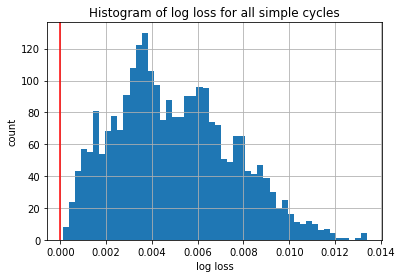

In [72]:
dg_order_book = order_book_to_dg(order_book)

# compute the sum of weights given a list of nodes
def loss(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle[0:-1], cycle[1:])])

# create a dictionary of all simple cycles
cycles = dict()
for cycle in nx.simple_cycles(dg_order_book):
    cycle.append(cycle[0])
    cycles[tuple(cycle)] = loss(cycle)

print(f"There are {len(cycles)} distinct simple cycles in the order book.")

log_loss = dict()
for cycle, w in cycles.items():
    log_loss[w] = cycle
    
plt.hist(cycles.values(), bins=int(np.sqrt(len(log_loss))))
ax = plt.gca()
ax.set_ylabel("count")
ax.set_xlabel("log loss")
ax.set_title("Histogram of log loss for all simple cycles")
ax.grid(True)
ax.axvline(0, color='r')

In [73]:
# minimum log loss cycle
cycle = min(cycles, key=cycles.get)
print(f"Cycle {cycle} has loss {cycles[cycle]}")

# maximum log loss cycl
cycle = max(cycles, key=cycles.get)
print(f"Cycle {cycle} has loss {cycles[cycle]}")

Cycle ('USDC', 'USDT', 'USDC') has loss 0.00010002500633496972
Cycle ('POLY', 'BUSD', 'MANA', 'BTC', 'TRX', 'USDT', 'POLY') has loss 0.013391096268916547


### Negative Edge Cycles

A brute force search over all simple cycles has complexity $(n + e)(c + 1)$ which is impractical for larger scale applications. A more efficient search based on Bellman-Ford is embedded in the NetworkX function `negative_edge_cycle` that returns a logical True if a negative cycle exists in a directed graph. 

In [78]:
dg_order_book = order_book_to_dg(order_book)
nx.negative_edge_cycle(dg_order_book, weight="weight")

False

Searching for an arbitrage opportunity. If a negative edge cycle is detected, the directed graph is saved as a .csv file for later anaysis.

In [93]:
from datetime import datetime

for k in range(0, 1000):
    now = str(datetime.now())
    order_book = fetch_order_book(dg_symbols)
    dg_order_book = order_book_to_dg(order_book)
    if nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True):
        print(k, now, " arb found")
        fname = f"order_book {str(datetime.now())}.csv"
        order_book.to_csv(fname)
        break
    else:
        print(k, now, " no arb")
        
fname = "order_book 2022-07-05 10:59:49.225255.csv"
order_book = pd.read_csv(fname)
dg_order_book = order_book_to_dg(order_book)
cycle = nx.find_negative_cycle(dg_order_book, "USD-SRC")
print(cycle, loss(cycle))

0 2022-07-29 08:57:01.405178  no arb
1 2022-07-29 08:57:05.416678  no arb
2 2022-07-29 08:57:08.630403  no arb
3 2022-07-29 08:57:12.138724  no arb
4 2022-07-29 08:57:15.254829  no arb
5 2022-07-29 08:57:18.376532  no arb
6 2022-07-29 08:57:21.506390  no arb
7 2022-07-29 08:57:24.637258  no arb
8 2022-07-29 08:57:27.736230  no arb
9 2022-07-29 08:57:30.880528  no arb
10 2022-07-29 08:57:34.042973  no arb
11 2022-07-29 08:57:37.226981  no arb
12 2022-07-29 08:57:40.485452  no arb
13 2022-07-29 08:57:43.715032  no arb
14 2022-07-29 08:57:47.273723  no arb
15 2022-07-29 08:57:50.569611  no arb
16 2022-07-29 08:57:53.824117  no arb
17 2022-07-29 08:57:56.998273  no arb
18 2022-07-29 08:58:00.196773  no arb
19 2022-07-29 08:58:03.301570  no arb
20 2022-07-29 08:58:06.473388  no arb
21 2022-07-29 08:58:09.609825  no arb
22 2022-07-29 08:58:12.748479  no arb
23 2022-07-29 08:58:15.964141  no arb
24 2022-07-29 08:58:19.342473  no arb
25 2022-07-29 08:58:22.638223  no arb
26 2022-07-29 08:58:25

### Retrieve Arbitrage

`find_negative_cycle`

['USDT', 'BTC', 'USDC', 'USDT'] -9.517519837469544e-05


## Shortest Path

In [173]:
def dg_shortest_path(dg_order_book):
    shortest_path = nx.shortest_path(
        dg_order_book, "USD-SRC", "USD-DST", weight="weight", method="bellman-ford"
    )

    S = 1.0
    x = np.inf
    for src, dst in zip(shortest_path, shortest_path[1:]):
        print(f"Sell {src}, Buy {dst}:")

        cap = dg_order_book.edges[(src, dst)]["capacity"]
        a = edges[(src, dst)]["conv"]
        print(f"     Max {src} on-hand = {x}")
        print(f"     Max trade = {cap} {src}")

        a = edges[(src, dst)]["conv"]
        S = S * a
        x = a * min(cap, x)

        print(f"     Price = {a} {dst} per {src}")
        print(f"     Max position after trade {dst} = {x}")

        print()

    print("Summary")
    print(f"Starting Position {x/S} USD")
    print(f"Final Position {x} USD")
    print(f"Net profit = {x - x/S}  ({100*(1 - 1/S):.5f}%)")


dg_shortest_path(dg_order_book)

Sell USD-SRC, Buy BTC:


KeyError: 'capacity'

In [ ]:
order_book = fetch_order_book(dg_symbols)
dg_order_book = order_book_to_dg(order_book)
dg_shortest_path(dg_order_book)

## Optimizing Wealth Creation

In [ ]:
import pyomo.environ as pyo

T = 10

m = pyo.ConcreteModel(f"{exchange} arbitrage")

# length of the trading chain
m.T0 = pyo.RangeSet(0, T)
m.T1 = pyo.RangeSet(1, T)

# currency nodes and trading edges
m.NODES = pyo.Set(initialize=nodes.keys())
m.EDGES = pyo.Set(initialize=edges.keys())

# "gain" on each trading edge
@m.Param(m.EDGES)
def a(m, src, dst):
    return 10 ** edges[(src, dst)]["log10_conv"]


# currency on hand at each node
m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

# amount traded on each edge
m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)


@m.Objective(sense=pyo.maximize)
def wealth(m):
    return m.w["USD-DST", T]


# initial assignment of 100 units on a selected currency
@m.Constraint(m.NODES)
def initial(m, node):
    if node == "USD-SRC":
        return m.w[node, 0] == 1.0
    return m.w[node, 0] == 0.0


@m.Constraint(m.NODES, m.T1)
def no_shorting(m, node, t):
    return m.w[node, t - 1] >= sum(
        m.x[node, dst, t] for src, dst in m.EDGES if src == node
    )


@m.Constraint(m.NODES, m.T1)
def balances(m, node, t):
    return m.w[node, t] == m.w[node, t - 1] - sum(
        m.x[node, dst, t] for src, dst in m.EDGES if src == node
    ) + sum(m.a[src, node] * m.x[src, node, t] for src, dst in m.EDGES if dst == node)


solver = pyo.SolverFactory("cbc")
solver.solve(m)

for node in m.NODES:
    print(f"{node:8s}", end="")
    for t in m.T0:
        print(f" {m.w[node, t]():12.8f}", end="")
    print()

print()

for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():0.8f}")
    print()

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
import math

n = len(nodes)


def visualize(bf):
    adot = Digraph()
    for node in bf.keys():
        w = 10 ** (-bf[node]["w"])
        if math.isinf(w):
            adot.node(node)
        else:
            adot.node(node, label=f"{node}\n{w:0.8f}")
        if bf[node]["prec"] is not None:
            adot.edge(bf[node]["prec"], node)
    display(adot)


# dictionary of all nodes.
#   prec: preceding node
#   w: weight

bf = {node: {"prec": None, "w": float("inf")} for node in nodes}
bf["USD-SRC"]["w"] = 0

for _ in range(n - 1):
    for edge in edges.keys():
        src, dst = edge
        w = -edges[edge]["log10_conv"]
        if bf[dst]["w"] > (bf[src]["w"] + w):
            bf[dst]["w"] = bf[src]["w"] + w
            bf[dst]["prec"] = src

visualize(bf)

## Bibliographic Notes

Crytocurrency markets are relatively new compared to other markets, and relatively few academic papers are available that specifically address arbitrage on those markets. Early studies, such as the following, reported periods of large, recurrent arbitrage opportunities that exist across exchanges, and that can persist for several days or weeks.

> Makarov, I., & Schoar, A. (2020). Trading and arbitrage in cryptocurrency markets. Journal of Financial Economics, 135(2), 293-319.

Subsequent work reports these prices differentials do exist, but only at a fraction of the values previously reported, and only for fleeting periods of time. 

> Crépellière, T., & Zeisberger, S. (2020). Arbitrage in the Market for Cryptocurrencies. Available at SSRN 3606053.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3606053

The use of network algorithms to identify cross-exchange arbitrage has appeared in the academic literature, and in numerous web sites demonstrating optimization and network applications. Representative examples are cited below.

> Peduzzi, G., James, J., & Xu, J. (2021, September). JACK THE RIPPLER: Arbitrage on the Decentralized Exchange of the XRP Ledger. In 2021 3rd Conference on Blockchain Research & Applications for Innovative Networks and Services (BRAINS) (pp. 1-2). IEEE. https://arxiv.org/pdf/2106.16158.pdf

> Bruzgė, R., & Šapkauskienė, A. (2022). Network analysis on Bitcoin arbitrage opportunities. The North American Journal of Economics and Finance, 59, 101562. https://doi.org/10.1016/j.najef.2021.101562

> Bruzgė, R., & Šapkauskienė, A. (2022). Dataset for Bitcoin arbitrage in different cryptocurrency exchanges. Data in Brief, 40, 107731. 

The work in this notebook is related to materials found in the following web resources.

> https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

> [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)

A more complete analysis of trading and exploiting arbitrage opportunities in decentralized finance markets is available in the following paper and thesis.

> Byrne, S. An Exploration of Novel Trading and Arbitrage Methods within Decentralised Finance. https://www.scss.tcd.ie/Donal.OMahony/bfg/202021/StephenByrneDissertation.pdf

> Levus, R., Berko, A., Chyrun, L., Panasyuk, V., & Hrubel, M. (2021). Intelligent System for Arbitrage Situations Searching in the Cryptocurrency Market. In CEUR Workshop Proceedings (pp. 407-440). http://ceur-ws.org/Vol-2917/paper32.pdf

In addition to the analysis of arbitrage opportunities, convex optimization may also have an important role in the developing of trading algorithms for crypocurrency exchanges.

> Angeris, G., Agrawal, A., Evans, A., Chitra, T., & Boyd, S. (2021). Constant function market makers: Multi-asset trades via convex optimization. arXiv preprint arXiv:2107.12484. https://baincapitalcrypto.com/constant-function-market-makers-multi-asset-trades-via-convex-optimization/ and https://arxiv.org/pdf/2107.12484.pdf





## Appendix: Asynchronous downloads of order book data

Considerably more development, testing, and validation would be needed to adapt this code to an automated tradign bot to exploit arbitrage opportunities in the crypto-currency markets. One of the time consuming steps is accessing order book data. The following cell is an experiment using the Python `asyncio` library to determine if asynchronous calls to the `ccxt` would provide faster downloads. 

Preliminary testing shows little or no advantage to `asyncio` when working with a single exchange. That may change when the above code is adapted to multi-exchange arbitrage, and therefore this code is retained below for future testing.

In [15]:
%%script echo skipping

from timeit import default_timer as timer

# asynchronous implementation
import asyncio
import nest_asyncio

my_symbols = ['/'.join(edge) for edge in edges]

async def afetch_order_book(symbol, limit=1, exchange=exchange):
    start_time = timer()
    result = exchange.fetch_order_book(symbol, limit)
    run_time = timer() - start_time
    return result

async def get_data():
    coroutines = [afetch_order_book(symbol) for symbol in my_symbols]
    await asyncio.gather(*coroutines)

start = timer()
nest_asyncio.apply()
asyncio.run(get_data())
run_time = timer() - start

print(run_time)

skipping


In [7]:
# trim currencies to those that appears as DST, or are N or more SRC

# all currencies trading in N or more base currencies
N = 4

src_nodes = list(src_count[src_count > N].index)
dst_nodes = list(dst_count[dst_count > 1].index)
src_dst_nodes = list(set(src_nodes + dst_nodes))

# plot a directed graph from the edges and nodes
label = f"{exchange}\ntrading symbols with {N} or more base currencies\n "
dg = Digraph(
    f"{exchange}",
    graph_attr={"label": label, "fontsize": "15", "labelloc": "t"},
    node_attr={"fontsize": "12"},
    edge_attr={"fontsize": "10"},
)

for node in src_nodes:
    label = f"{node}"
    dg.node(node, label, style="filled", fillcolor="lightblue")

for node in dst_nodes:
    label = f"{node}"
    dg.node(node, label, style="filled", fillcolor="gold")

trade_edges = [
    [src, dst]
    for src, dst in src_dst_pairs
    if (src in src_dst_nodes) and (dst in src_dst_nodes)
]
for src, dst in trade_edges:
    symbol = "/".join([src, dst])
    label = f"{symbol}"
    dg.edge(src, dst, label)

display(dg)
dg.format = "png"
dg.view("exchange-symbol-map")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH